# Introduction

This notebook explores an addition to the model free detection method.  Model free detection struggled during extended times of low irradiance.  This addition will filter periods of low irradiance based on the zscore.  For this method, a user must submit a number of days at a time so that zscoring can occur (here we use two weeks - it is unwise to use a very large time frame since seasonal affects may come affect filtering).

# Imports, configs, etc

In [1]:
import numpy as np
import pandas as pd
import datetime
import pvlib
import clearsky_detect_model_free
import preprocess

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import os, sys
lib_path = os.path.abspath(os.path.join('..', 'rdtools'))
sys.path.append(lib_path)
import filtering

import warnings

%load_ext autoreload
%autoreload 2

# Setup

## Load data

Weather and performance data are taken at 1min intervals.  Supplier is the Sandia National Lab Regional Test Center in Albuquerque, NM.  Data spans roughly 2016-April 2017.  This data was scraped from PVDAQ (http://bit.ly/2mKrOwG).  The meteorological data and the performance data are contained in two separate files (technically separate systems - PV system and meteorological station).

In [2]:
def load_snl():
    filename = os.path.expanduser('~/data_sets/snl_raw_data/1429_1405/raw_1405_weather_for_1429.csv')
    cols = ['Global_Wm2', 'Date-Time']
    data = pd.read_csv(filename, parse_dates=['Date-Time'], usecols=cols, index_col=['Date-Time'])
    data.index = data.index.tz_localize('Etc/GMT+7')
    data = data.reindex(pd.date_range(start=data.index[0], end=data.index[-1], freq='1min')).fillna(0)
    data = pd.Series(data['Global_Wm2'], index=data.index)
    data[data < 0] = 0 
    return data

In [3]:
def load_srrl():
    srrl_file = os.path.expanduser('~/data_sets/srrl/20140101.csv')
    srrl_data = pd.read_csv(srrl_file)
    srrl_data.index = pd.to_datetime(srrl_data['DATE (MM/DD/YYYY)'] + ' ' + srrl_data['MST'])
    srrl_data.index = srrl_data.index.tz_localize('Etc/GMT+7')
    srrl_data = srrl_data[~srrl_data.index.duplicated(keep='first')]
    srrl_data.drop(['DATE (MM/DD/YYYY)', 'MST'], inplace=True, axis=1)
    srrl_data = pd.Series(srrl_data['Global 40-South LI-200 [W/m^2]'], index=srrl_data.index)
    srrl_data[srrl_data < 0] = 0
    srrl_data2 = pd.Series(0, index=pd.date_range(start=srrl_data.index.date[0], end=srrl_data.index.date[-1] + pd.Timedelta('1D'), freq='1min'))
    srrl_data2.index = srrl_data2.index.tz_localize('Etc/GMT+7')
    srrl_data2[srrl_data.index] = srrl_data
    srrl_data = srrl_data2.copy()
    return srrl_data

In [4]:
snl_data = load_snl()
srrl_data = load_srrl()

## Set up PVLib systems

In [5]:
def make_pvlib_sys(tilt, elevation, azimuth, lat, lon):
    sys_no_loc = pvlib.pvsystem.PVSystem(surface_tilt=tilt, surface_azimuth=azimuth)
    sys_loc = pvlib.location.Location(lat, lon, altitude=elevation)
    sys = pvlib.pvsystem.LocalizedPVSystem(pvsystem=sys_no_loc, location=sys_loc)
    return sys

In [6]:
snl_params = {'tilt': 35, 'elevation': 1658, 'azimuth': 180, 'lat': 35.0549, 'lon': -106.5433}
rtc = make_pvlib_sys(**snl_params)

In [7]:
srrl_params = {'tilt': 40, 'elevation': 1828.8, 'azimuth': 180, 'lat': 39.742, 'lon': -105.18}
srrl = make_pvlib_sys(**srrl_params)

## Analysis functions

In [8]:
def compare_plot(sample, is_clear, is_clear_filtered, is_clear_pvlib):
    fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(8, 5), sharex=False)

    ax = axes[0]
    _ = ax.plot(sample.index, sample)
    _ = ax.scatter(sample.index[is_clear & ~is_clear_filtered], sample[is_clear & ~is_clear_filtered], 
                   facecolor='none', edgecolor='green', label='unfiltered')
    _ = ax.scatter(sample.index[is_clear_filtered & ~is_clear], sample[is_clear_filtered & ~is_clear], 
                   facecolor='none', edgecolor='red', label='filtered')
    _ = ax.scatter(sample.index[is_clear_filtered & is_clear], sample[is_clear & is_clear_filtered], 
                   facecolor='none', edgecolor='orange', label='both')
    _ = ax.scatter(sample.index[is_clear_pvlib], sample[is_clear_pvlib], 
                   marker='.', color='black', label='pvlib')
    _ = ax.legend()
    
    tmp_df = pd.DataFrame()
    
    tmp_df['unfiltered'] = is_clear
    tmp_df['filtered'] = is_clear_filtered
    tmp_df['pvlib'] = is_clear_pvlib
    
    tmp_df = tmp_df.resample('D').sum()
    tmp_df.index = tmp_df.index.date
    
    tmp_df.plot(kind='bar', ax=axes[1])
    
    fig.tight_layout()

# Investigation

## SNL RTC

In [9]:
sample = snl_data[(snl_data.index >= '2016-07-01') & (snl_data.index < '2016-08-01')]

/Users/benellis/rdtools/model_free/preprocess.py:171: RuntimeWarning: invalid value encountered in less
  mask_vals = pd.Series(((group.values < lower_lim.values) | (group.values > upper_lim.values)),
/Users/benellis/rdtools/model_free/preprocess.py:171: RuntimeWarning: invalid value encountered in greater
  mask_vals = pd.Series(((group.values < lower_lim.values) | (group.values > upper_lim.values)),


<IPython.core.display.Javascript object>


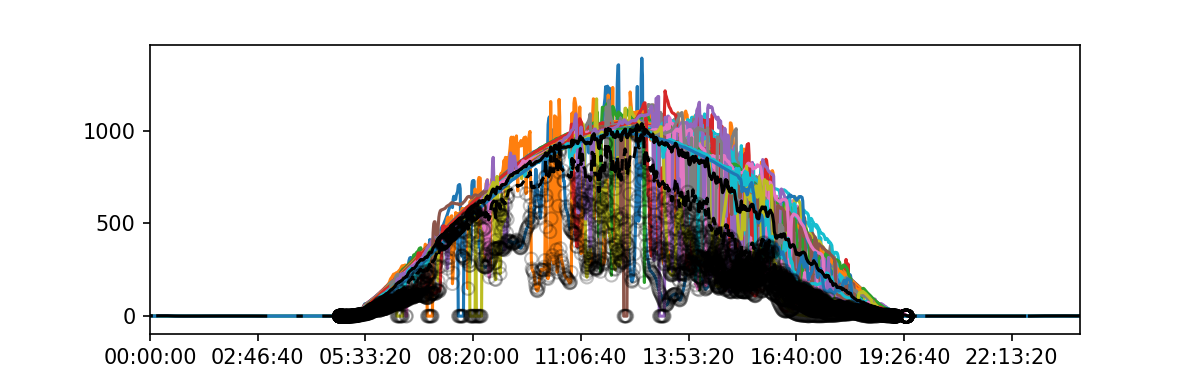

In [10]:
filtered_sample, components = preprocess.deviation_time_filter(sample, mode='zscore', dev_range=(-1, np.inf), 
                                                               verbose=True, viz=True)

In [11]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    clear_skies = rtc.get_clearsky(sample.index)
    clear_skies = pd.Series(clear_skies['ghi'], index=sample.index)
    is_clear_pvlib = pvlib.clearsky.detect_clearsky(sample, clear_skies, sample.index, 10)

### Standard method

In [12]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    is_clear, result = clearsky_detect_model_free.model_free_detect(sample, verbose=True)

In [13]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    is_clear_filtered, result_filtered = clearsky_detect_model_free.model_free_detect(filtered_sample, verbose=True)

In [14]:
print(len(is_clear[is_clear]), len(is_clear_filtered[is_clear_filtered]), len(is_clear_pvlib[is_clear_pvlib]))

18042 14892 15458


<IPython.core.display.Javascript object>


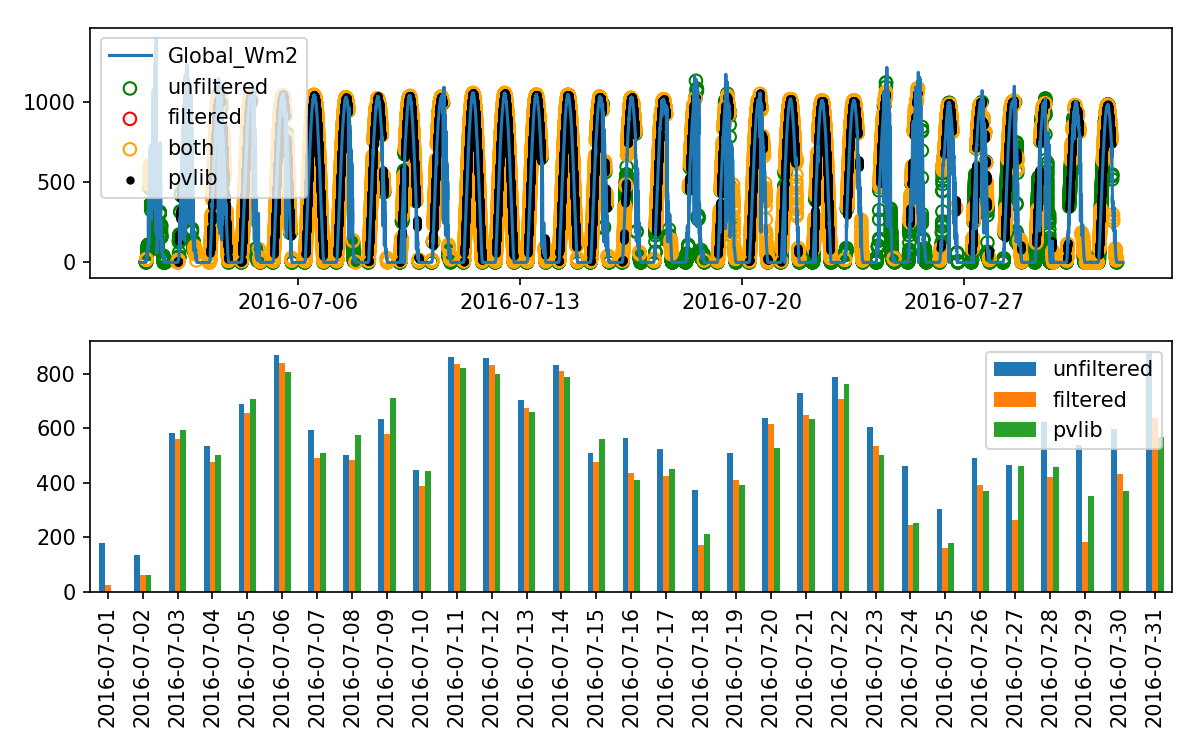

In [15]:
compare_plot(sample, is_clear, is_clear_filtered, is_clear_pvlib)

Filtering (expectedly) leads to lessp eriods of clear sky detected.  We see that on July 1st and 2nd we have obvious improvement over unfiltered (green) sample.  We miss some periods that look obviously clear though, such as July 14th in the morning.

### Mean method

In [16]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    is_clear, result = clearsky_detect_model_free.model_free_detect_meanval(sample, verbose=True)

In [17]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    is_clear_filtered, result_filtered = clearsky_detect_model_free.model_free_detect_meanval(filtered_sample, verbose=True)

In [18]:
print(len(is_clear[is_clear]), len(is_clear_filtered[is_clear_filtered]), len(is_clear_pvlib[is_clear_pvlib]))

17102 13025 15458


<IPython.core.display.Javascript object>


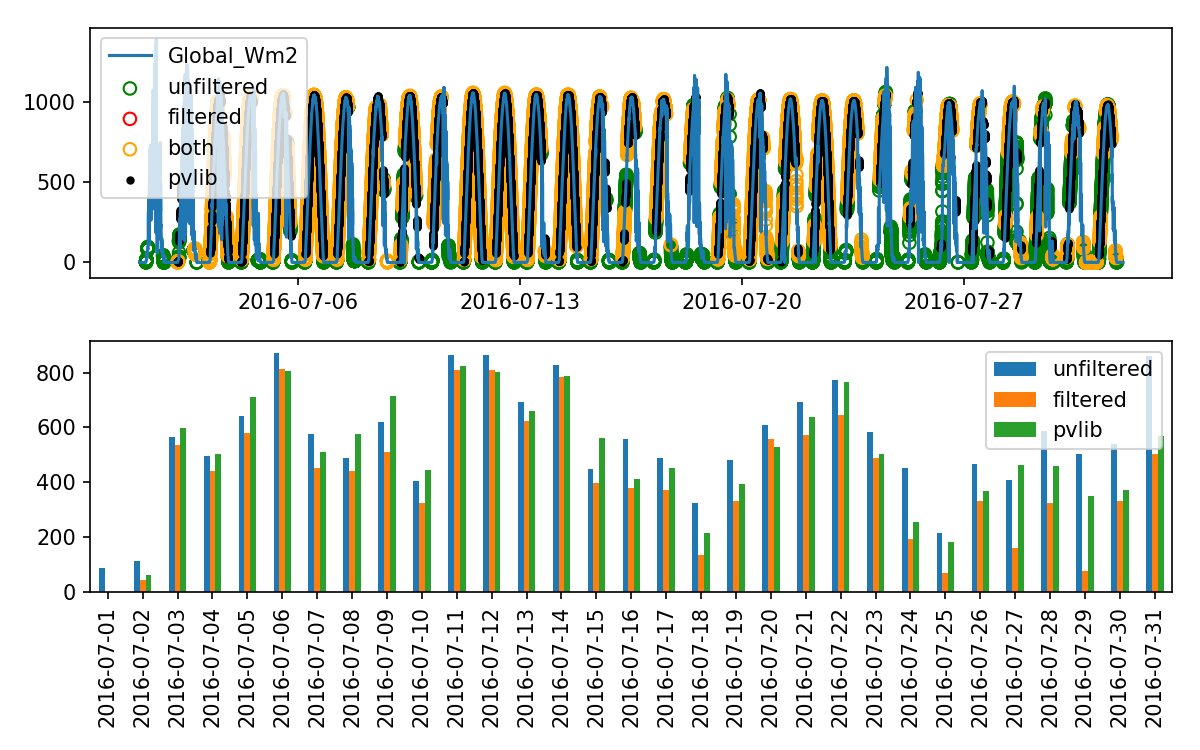

In [19]:
compare_plot(sample, is_clear, is_clear_filtered, is_clear_pvlib)

The mean method performs similary to what we saw in the standard method.  Again we note that some points of seemingly obvious clarity are labeled as unclear when filtered.

### Democratic method

In [20]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    is_clear, result = clearsky_detect_model_free.model_free_detect_democratic(sample, verbose=True)

In [21]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    is_clear_filtered, result_filtered = clearsky_detect_model_free.model_free_detect_democratic(filtered_sample, verbose=True)

In [22]:
print(len(is_clear[is_clear]), len(is_clear_filtered[is_clear_filtered]), len(is_clear_pvlib[is_clear_pvlib]))

17184 14100 15458


<IPython.core.display.Javascript object>


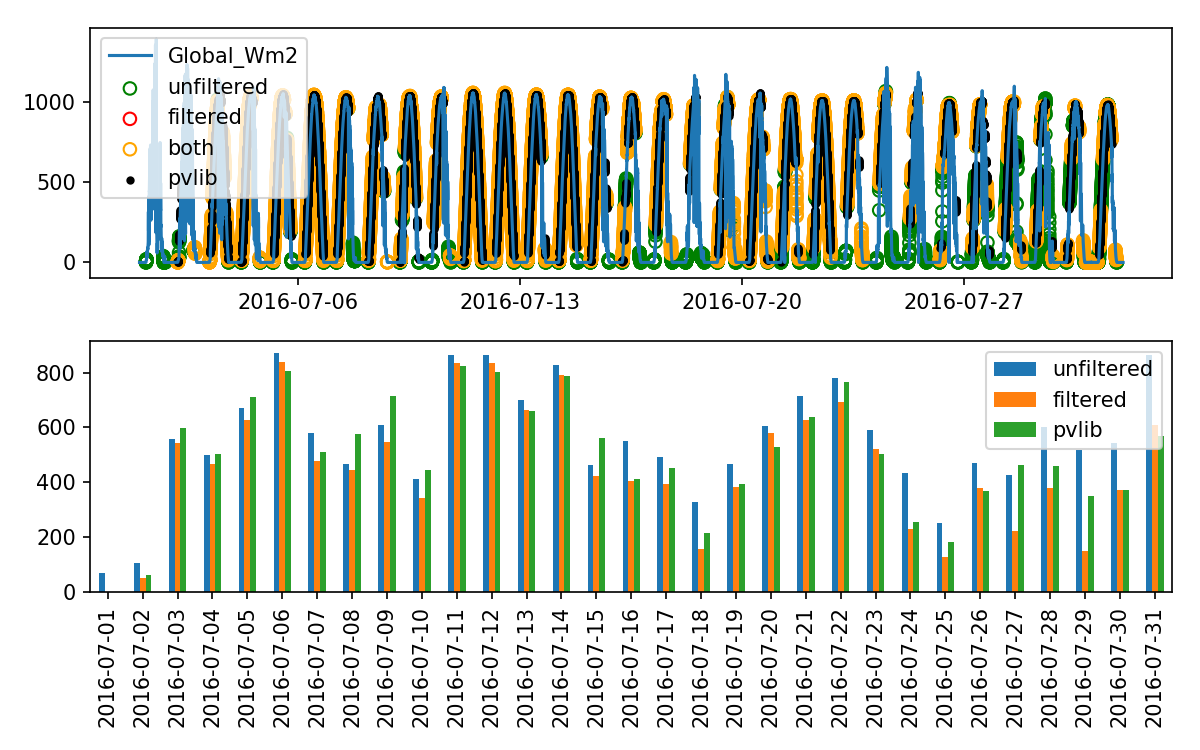

In [23]:
compare_plot(sample, is_clear, is_clear_filtered, is_clear_pvlib)

Again, we see similar performance with locations where clarity is not caught due to filtering.

## SRRL

In [24]:
sample = srrl_data[(srrl_data.index >= '2014-01-01') & (srrl_data.index < '2014-02-01')]

<IPython.core.display.Javascript object>


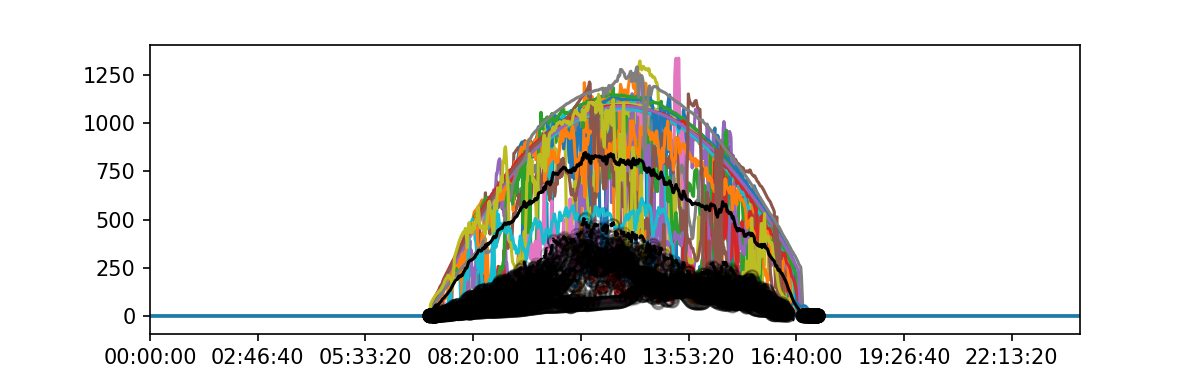

In [29]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    filtered_sample, components = preprocess.deviation_time_filter(sample, mode='zscore', dev_range=(-1, np.inf),
                                                                   verbose=True, viz=True)

In [30]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    clear_skies = rtc.get_clearsky(sample.index)
    clear_skies = pd.Series(clear_skies['ghi'], index=sample.index)
    is_clear_pvlib = pvlib.clearsky.detect_clearsky(sample, clear_skies, sample.index, 10)

### Standard method

In [31]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    is_clear, result = clearsky_detect_model_free.model_free_detect(sample, verbose=True)

In [32]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    is_clear_filtered, result_filtered = clearsky_detect_model_free.model_free_detect(filtered_sample, verbose=True)

In [33]:
print(len(is_clear[is_clear]), len(is_clear_filtered[is_clear_filtered]), len(is_clear_pvlib[is_clear_pvlib]))

8968 6264 15


<IPython.core.display.Javascript object>


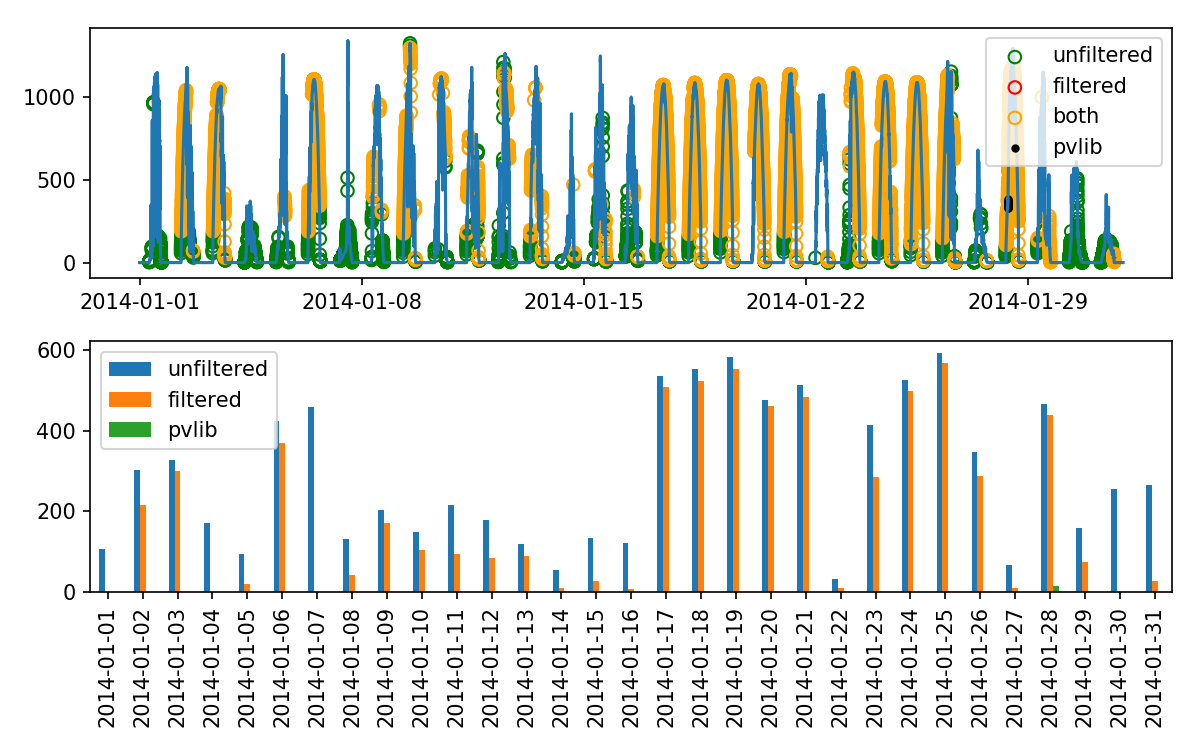

In [34]:
compare_plot(sample, is_clear, is_clear_filtered, is_clear_pvlib)

Filtering improves performance great on the obviously cloudy days (January 1, 4, 7).  We also see cloudy portions of certain days are also ignored (January 2, 11, 12) that were not caught by the unfiltered samlpe.

### Mean method

In [35]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    is_clear, result = clearsky_detect_model_free.model_free_detect_meanval(sample, verbose=True)

In [36]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    is_clear_filtered, result_filtered = clearsky_detect_model_free.model_free_detect_meanval(filtered_sample, verbose=True)

In [37]:
print(len(is_clear[is_clear]), len(is_clear_filtered[is_clear_filtered]), len(is_clear_pvlib[is_clear_pvlib]))

8250 5537 15


<IPython.core.display.Javascript object>


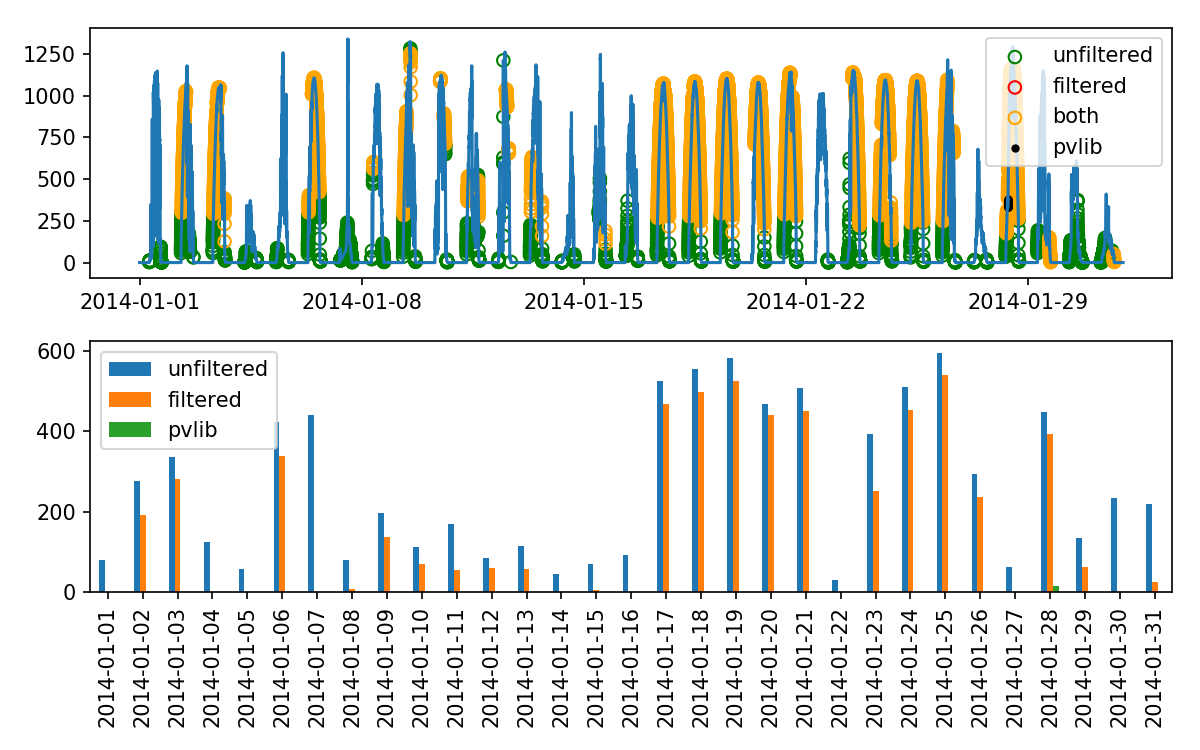

In [38]:
compare_plot(sample, is_clear, is_clear_filtered, is_clear_pvlib)

Filtering wit hthe mean method further improves results by removing some points during cloudy periods.

### Democratic method

In [39]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    is_clear, result = clearsky_detect_model_free.model_free_detect_democratic(sample, verbose=True)

In [40]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    is_clear_filtered, result_filtered = clearsky_detect_model_free.model_free_detect_democratic(filtered_sample, verbose=True)

In [41]:
print(len(is_clear[is_clear]), len(is_clear_filtered[is_clear_filtered]), len(is_clear_pvlib[is_clear_pvlib]))

8372 5899 15


<IPython.core.display.Javascript object>


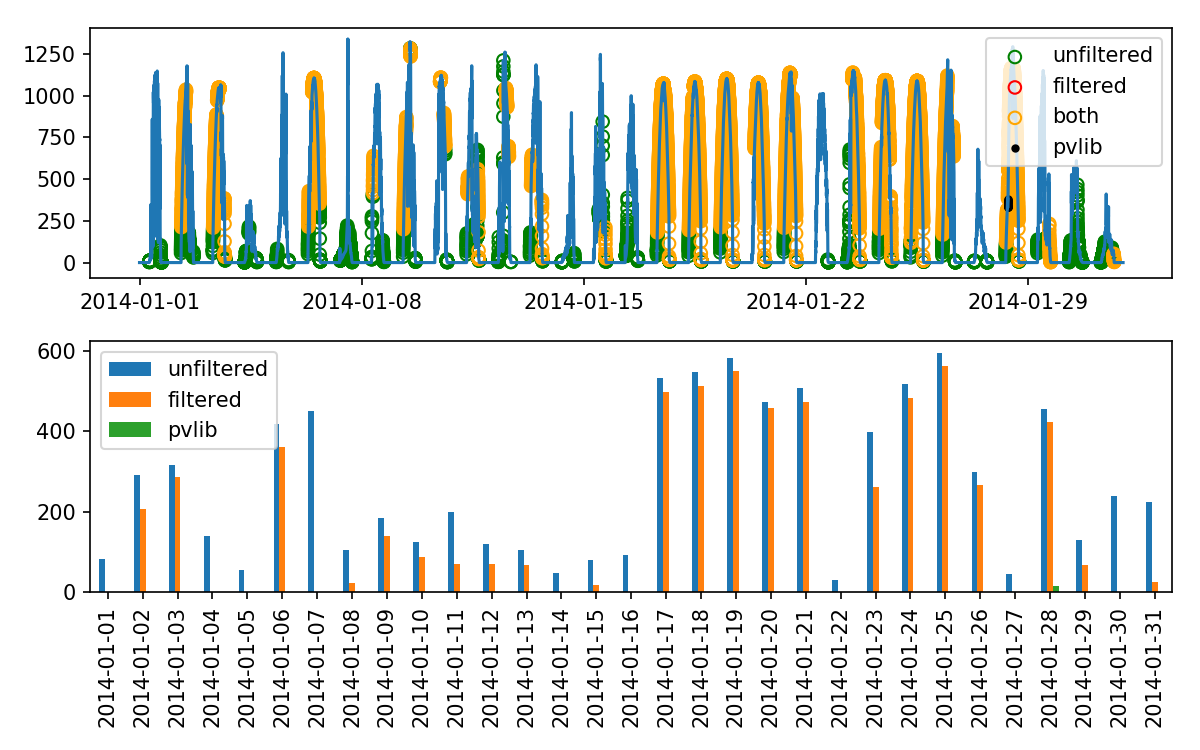

In [42]:
compare_plot(sample, is_clear, is_clear_filtered, is_clear_pvlib)

Filtering with the democratic method gives similar results as the mean method.  We do see that some periods on January 7 are labeled clear which is obviously wrong.

# Conclusion

The filtering based on avg - std does seem to work well for for the samples above.  It does remove some of the obvious flaws that were seen in unfiltered data sets.  Unfortunately we saw that it did remove some periods of obvious clarity from certain days.  This might be solved by using a different zscore cutoff or using a different metric for outlier filtering (median deviation, percentile, etc?).





# MISC